# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [28]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_quantum
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum-rand"

nb_devices_for_the_run = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Handling non-iid data

Following columns has missing values: [21, 22, 23, 30, 45, 46, 47, 56]
The columns with empty values have been removed.
This columns are empty: [40, 41, 42, 43, 44]
Now, there is 65 dimensions.
Head of the dataset (columns has not been re-indexed).
   state         2         3         4    5         6    7         8    9  \
0     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
1     -1  0.920167  0.817883 -0.646473 -1.0  0.000000  0.0  0.000000  0.0   
2      1  0.868397  0.178202  0.150828 -1.0  0.000000  0.0  0.000000  0.0   
3     -1  0.000000  0.000000  0.000000  0.0  1.577894  0.0 -0.369792 -1.0   
4     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   

         10  ...   70        71        72        73        74        75   76  \
0  0.876238  ... -1.0 -0.036906 -0.000724  0.000000  0.000000  0.000000  0.0   
1  0.401383  ... -1.0 -0.999927 -0.012102  0.920167  0.817883 -0.646473 -1.0   
2  0.773496  ...  1.0  0.908824  0.550843  0.868

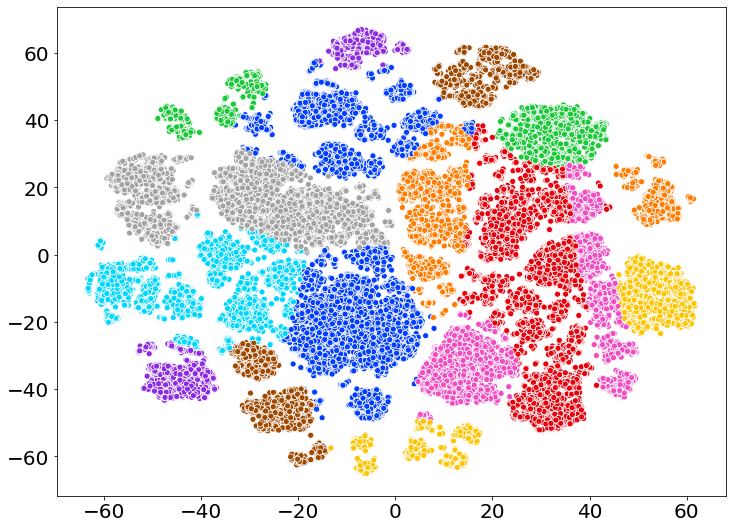

In [2]:
%%time
nb_cluster = nb_devices_for_the_run
X, Y, dim_notebook = prepare_quantum(nb_cluster, iid=False)

In [3]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.39624556062912225
ratio of state 1 on this device:  0.9188921859545005
ratio of state 1 on this device:  0.4898897058823529
ratio of state 1 on this device:  0.0012642225031605564
ratio of state 1 on this device:  0.24748646558391338
ratio of state 1 on this device:  0.48473748473748474
ratio of state 1 on this device:  0.4220643543669035
ratio of state 1 on this device:  0.540224032586558
ratio of state 1 on this device:  0.45410235580828595
ratio of state 1 on this device:  0.5100229095074456
ratio of state 1 on this device:  0.6459042135566606
ratio of state 1 on this device:  0.42004078065831635
ratio of state 1 on this device:  0.6226692836113837
ratio of state 1 on this device:  0.5859502632056635
ratio of state 1 on this device:  0.08495981630309989
ratio of state 1 on this device:  0.3948948948948949
ratio of state 1 on this device:  0.986651411

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_cluster)

In [10]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=5000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    1000 | 5.2484e-01
    2000 | 5.2482e-01
    3000 | 5.2482e-01
    4000 | 5.2482e-01
Gradient Descent: execution time=53.033 seconds
Final loss : 0.52482

CPU times: user 3min 29s, sys: 1.54 s, total: 3min 31s
Wall time: 53 s


In [33]:
%%time
batch_size = 400
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION_RAND):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               compression_model = SQuantization(2, dim_notebook-1),
                                               use_averaging=False, stochastic=False, batch_size=batch_size, 
                                               nb_epoch=500, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-{1}".format(filename, batch_size))

100%|██████████| 6/6 [01:10<00:00, 11.80s/it]

CPU times: user 4min 39s, sys: 2.45 s, total: 4min 42s
Wall time: 1min 11s


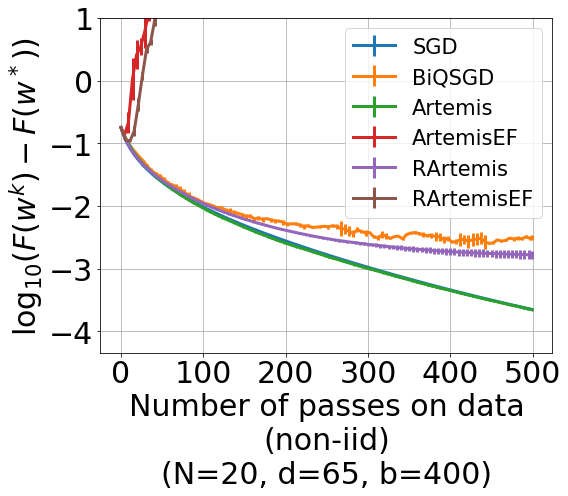

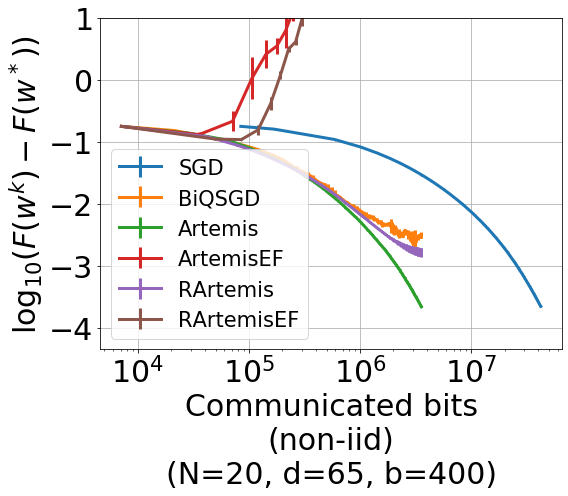

In [34]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)", ylim=True) 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj), ylim=True) 

## Gamma limit

In [8]:
step_formula = [(lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L)),
                (lambda it, L, omega, N: 1 / (64*L)),
                ]

label_step_formula = ["N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$",
                "$64L^{-1}$",
                ]

In [29]:
%%time
batch_size = 400
all_kind_of_compression_res = []
all_descent_various_gamma = {}
descent_by_algo_and_step_size = {}

#Corresponds to descent with optimal gamma for each algorithm
optimal_descents = {}

for type_params in tqdm(KIND_COMPRESSION_RAND):
    losses_by_comp = []
    losses_avg_by_comp = []
    descent_by_step_size = {}
    for (formula, label) in zip(step_formula, label_step_formula):
        multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                                   use_averaging=True, stochastic=False, batch_size=batch_size, 
                                                   step_formula=formula, 
                                                   compression_model = SQuantization(2, dim_notebook-1),
                                                   nb_epoch=250, logs_file="{0}.txt".format(filename))
        
        descent_by_step_size[label] = multiple_sg_descent
        losses_by_formula, losses_avg_by_formula = [], []
        
        # Picking the minimum values for each of the run.
        for sequence_of_losses, sequence_of_losses_avg in zip(multiple_sg_descent.losses, multiple_sg_descent.averaged_losses):
            losses_by_formula.append(min(sequence_of_losses))
            losses_avg_by_formula.append(min(sequence_of_losses_avg))
        losses_by_comp.append(losses_by_formula)
        losses_avg_by_comp.append(losses_avg_by_formula)
        
    descent_by_algo_and_step_size[type_params.name()] = ResultsOfSeveralDescents(descent_by_step_size, nb_devices_for_the_run)
    
    # Find optimal descent for the algo:
    min_loss_desc = 10e12
    opt_desc = None
    for desc in descent_by_step_size.values():
        if min_loss_desc > min([desc.losses[j][-1] for j in range(len(desc.losses))]):
            min_loss_desc = min([desc.losses[j][-1] for j in range(len(desc.losses))])
            opt_desc = desc
    # Adding the optimal descent to the dict of optimal descent
    optimal_descents[type_params.name()] = opt_desc
    
    artificial_multiple_descent = MultipleDescentRun()
    artificial_multiple_descent.append_list(losses_by_comp, losses_avg_by_comp)
    all_descent_various_gamma[type_params.name()] = artificial_multiple_descent
    all_kind_of_compression_res.append(all_descent_various_gamma)
    
res_various_gamma = ResultsOfSeveralDescents(all_descent_various_gamma, nb_devices_for_the_run)
pickle_saver(res_various_gamma, "{0}-alldescent".format(filename))

res_opt_gamma = ResultsOfSeveralDescents(optimal_descents, nb_devices_for_the_run)
pickle_saver(res_opt_gamma, "{0}-optimal_descents".format(filename))

pickle_saver(descent_by_algo_and_step_size, "{0}-descent_by_algo_and_step_size".format(filename))

100%|██████████| 6/6 [08:27<00:00, 84.55s/it]


CPU times: user 33min 19s, sys: 18 s, total: 33min 37s
Wall time: 8min 28s


### Without averaging

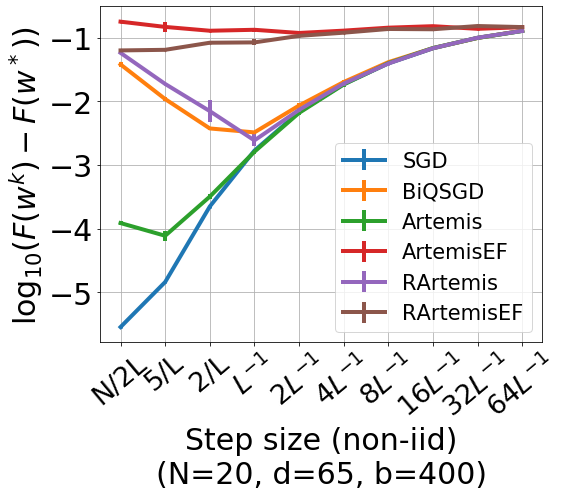

In [30]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Step size (non-iid)", one_on_two_points=False,
               xlabels=label_step_formula) 

### With averaging

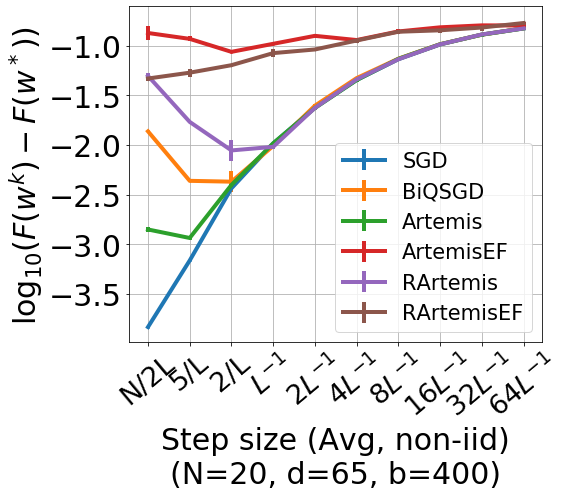

In [31]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-alldescent".format(filename))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size (Avg, non-iid)", one_on_two_points=False,
               xlabels=label_step_formula) 


### Display loss for each algorithm

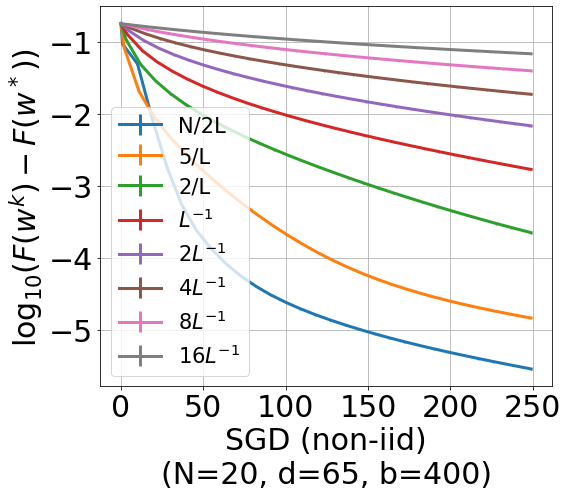

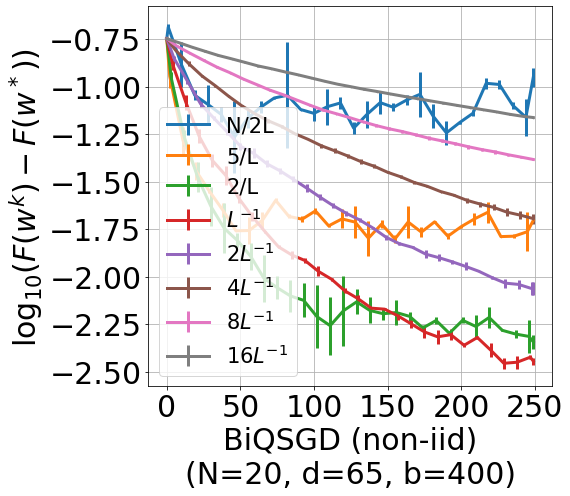

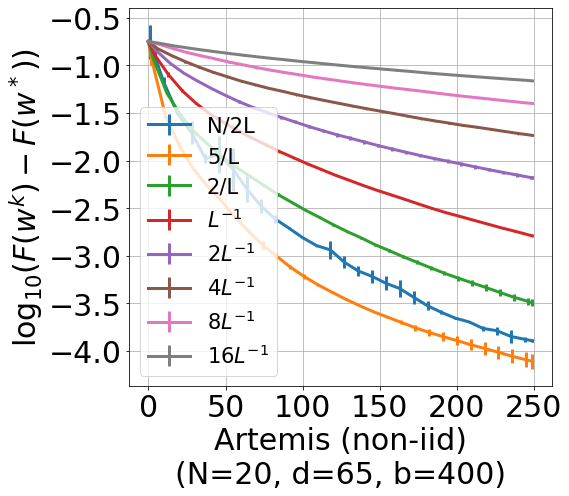

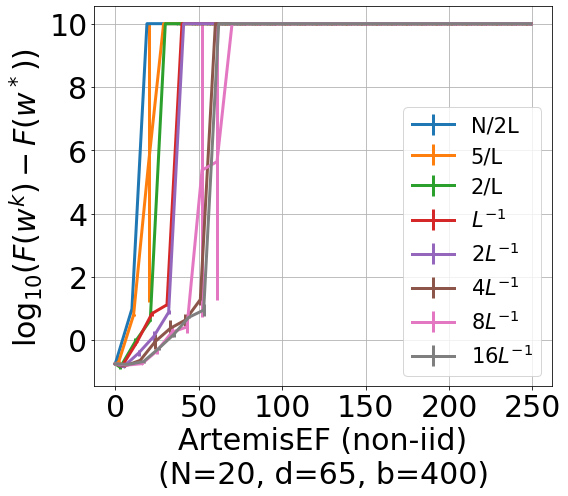

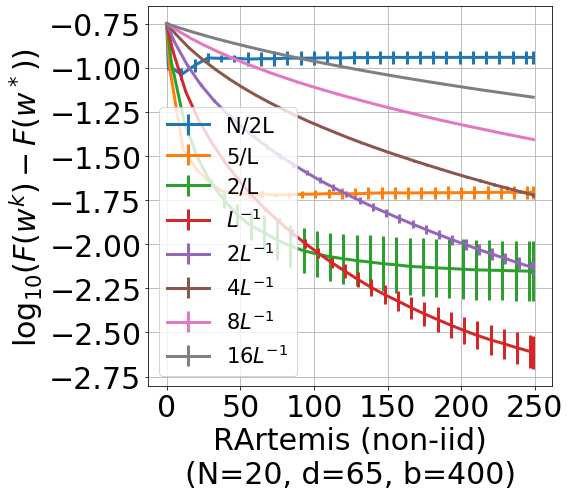

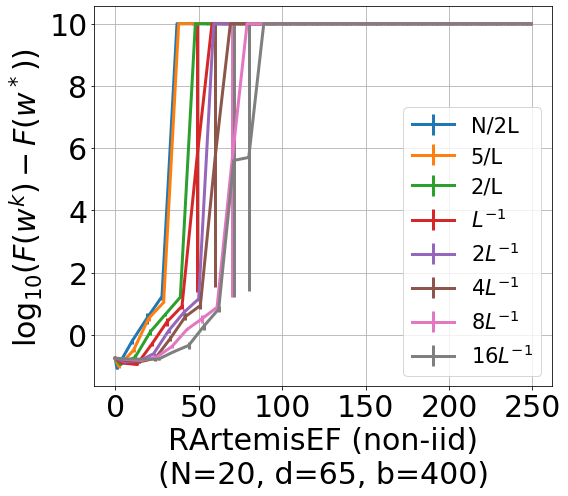

In [32]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-descent_by_algo_and_step_size".format(filename))
for algo_name, algo in res.items():
    plot_error_dist(algo.get_loss(obj), algo.names, algo.nb_devices_for_the_run, dim_notebook, 
                    batch_size=batch_size, all_error=algo.get_std(obj), x_legend="{0} (non-iid)".format(algo_name)) 


# All algorithms

In [24]:
%%time
def step_formulat(it, L, omega, N): return 5 / (20*L)
batch_size = 400
all_descent = {}
for type_params in tqdm([BiQSGD_unb(), BiQSGD_b(), BiQSGD_Feed_unb(), BiQSGD_Feed_b()]):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=False, stochastic=False, batch_size=batch_size, 
                                               nb_epoch=100, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-{1}".format(filename, batch_size))

100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

CPU times: user 17.2 s, sys: 104 ms, total: 17.3 s
Wall time: 4.34 s


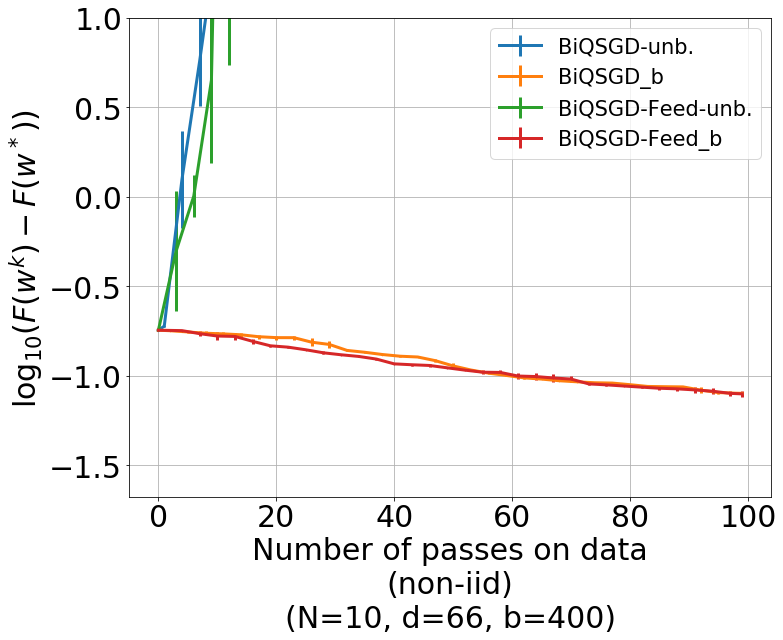

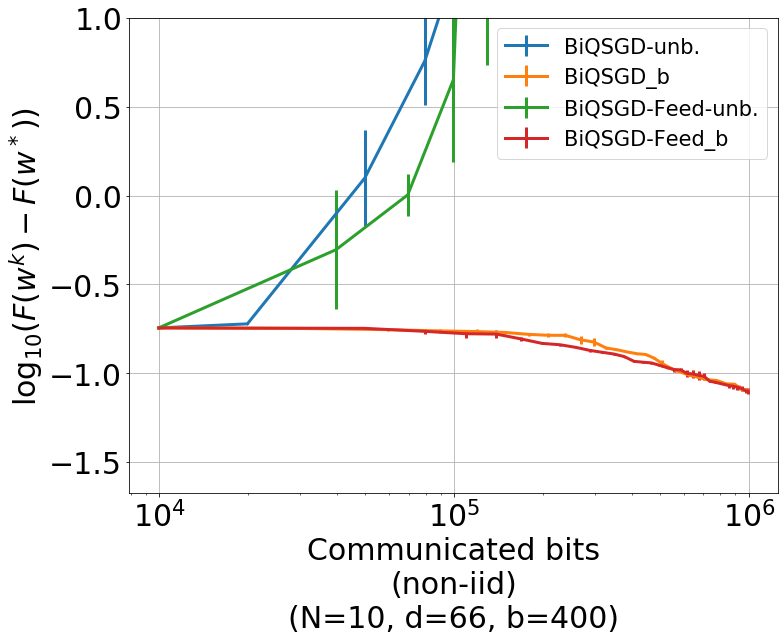

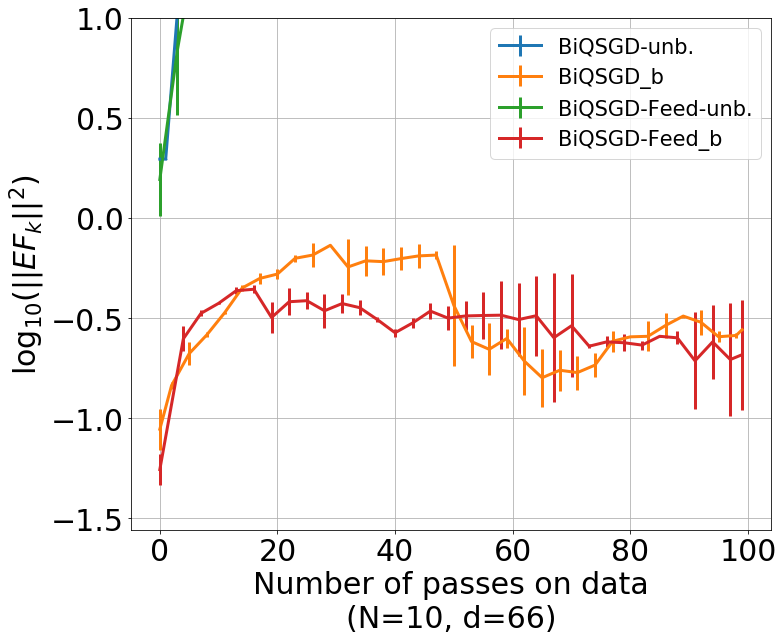

In [25]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook,
                all_error=res.get_error_feedback_std(obj), ylegends=r"$\log_{10}(||EF_k||^2$)")